In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path 
import os
import seaborn as sns

In [3]:
df = pd.read_csv("mean.csv")
df

,AUC,ExecutionTime,seed,fraction,drops,noise,Runs,Model,useclass
0,0.910,0.036,42,1.00,0,0.0,20,LogisticRegression,True
1,0.910,0.031,42,1.00,1,0.0,20,LogisticRegression,True
2,0.910,0.041,42,1.00,2,0.0,20,LogisticRegression,True
3,0.910,0.029,42,1.00,3,0.0,20,LogisticRegression,True
4,0.910,0.031,42,1.00,4,0.0,20,LogisticRegression,True
...,...,...,...,...,...,...,...,...,...
2515,0.502,1.021,314,0.25,0,3.0,20,SVM,True
2516,0.498,0.934,314,0.25,1,3.0,20,SVM,True
2517,0.481,0.995,314,0.25,2,3.0,20,SVM,True
2518,0.536,0.873,314,0.25,3,3.0,20,SVM,True


In [4]:
agg_df = df.drop(['Runs', 'useclass'], axis=1).groupby(['fraction','drops','noise','Model']).mean()
agg_df.drop('seed', axis=1, inplace=True)
agg_df

AUC  ExecutionTime
fraction drops noise Model                                      
0.25     0     0.0   AdaBoost            0.909833       0.179167
                     Decision Tree       0.739167       0.015667
                     GradientBoosting    0.908667       0.323167
                     LogisticRegression  0.896167       0.017667
                     NeuralNetwork       0.908833       2.430167
...                                           ...            ...
1.00     4     3.0   GradientBoosting    0.682667       0.567667
                     LogisticRegression  0.684333       0.029667
                     NeuralNetwork       0.684333       2.544667
                     RandomForest        0.683333       0.475167
                     SVM                 0.499333      13.041667

[420 rows x 2 columns]

In [5]:
resultsdf = agg_df.T.melt(ignore_index=False)
auc_df = resultsdf[resultsdf.index == 'AUC']
auc_df = auc_df.reset_index().drop('index', axis=1)
auc_df = auc_df.round(3)
auc_df.rename(columns={'value': 'auc'}, inplace=True)
auc_df

,fraction,drops,noise,Model,auc
0,0.25,0,0.0,AdaBoost,0.910
1,0.25,0,0.0,Decision Tree,0.739
2,0.25,0,0.0,GradientBoosting,0.909
3,0.25,0,0.0,LogisticRegression,0.896
4,0.25,0,0.0,NeuralNetwork,0.909
...,...,...,...,...,...
415,1.00,4,3.0,GradientBoosting,0.683
416,1.00,4,3.0,LogisticRegression,0.684
417,1.00,4,3.0,NeuralNetwork,0.684
418,1.00,4,3.0,RandomForest,0.683


In [45]:
resultsdf = agg_df.T.melt(ignore_index=False)
time_df = resultsdf[resultsdf.index == 'ExecutionTime']
time_df = time_df.reset_index().drop('index', axis=1)
time_df = time_df.round(3)
time_df.rename(columns={'value': 'time'}, inplace=True)
time_df

,fraction,drops,noise,Model,time
0,0.25,0,0.0,AdaBoost,0.179
1,0.25,0,0.0,Decision Tree,0.016
2,0.25,0,0.0,GradientBoosting,0.323
3,0.25,0,0.0,LogisticRegression,0.018
4,0.25,0,0.0,NeuralNetwork,2.430
...,...,...,...,...,...
415,1.00,4,3.0,GradientBoosting,0.568
416,1.00,4,3.0,LogisticRegression,0.030
417,1.00,4,3.0,NeuralNetwork,2.545
418,1.00,4,3.0,RandomForest,0.475


In [46]:
df = pd.concat([auc_df, time_df['time']], axis=1)
df = df.query("noise == 0")
df = df.set_index(['fraction', 'drops', 'noise', 'Model']	)
df

auc    time
fraction drops noise Model                            
0.25     0     0.0   AdaBoost            0.910   0.179
                     Decision Tree       0.739   0.016
                     GradientBoosting    0.909   0.323
                     LogisticRegression  0.896   0.018
                     NeuralNetwork       0.909   2.430
...                                        ...     ...
1.00     4     0.0   GradientBoosting    0.911   0.728
                     LogisticRegression  0.903   0.030
                     NeuralNetwork       0.912   4.855
                     RandomForest        0.886   0.797
                     SVM                 0.695  16.227

[105 rows x 2 columns]

local results

In [47]:
df_auc = df.drop(['time'], axis=1).unstack(level=3)
loss_auc = df_auc.loc[(1,0,0)] - df_auc
loss_auc = loss_auc.round(3).droplevel(2)
loss_auc = loss_auc.T.droplevel(0).T
loss_auc = loss_auc.melt(value_name='loss_auc', ignore_index=False).reset_index()
loss_auc

,fraction,drops,Model,loss_auc
0,0.25,0,AdaBoost,0.002
1,0.25,1,AdaBoost,0.002
2,0.25,2,AdaBoost,0.003
3,0.25,3,AdaBoost,0.002
4,0.25,4,AdaBoost,0.002
...,...,...,...,...
100,1.00,0,SVM,0.000
101,1.00,1,SVM,0.019
102,1.00,2,SVM,0.003
103,1.00,3,SVM,0.028


In [48]:
df_time = df.drop(['auc'], axis=1).unstack(level=3)
speedup_df = df_time.loc[(1,0,0)]/df_time
speedup_df = speedup_df.round(3).droplevel(2)
speedup_df = speedup_df.T.droplevel(0).T
speedup_df = speedup_df.melt(value_name='speedup', ignore_index=False).reset_index()
speedup_df

,fraction,drops,Model,speedup
0,0.25,0,AdaBoost,2.101
1,0.25,1,AdaBoost,2.173
2,0.25,2,AdaBoost,2.161
3,0.25,3,AdaBoost,2.238
4,0.25,4,AdaBoost,2.279
...,...,...,...,...
100,1.00,0,SVM,1.000
101,1.00,1,SVM,1.066
102,1.00,2,SVM,1.101
103,1.00,3,SVM,1.100


In [49]:
data = pd.concat([speedup_df, auc_df.auc, time_df.time, loss_auc.loss_auc], axis=1).dropna()#.query('speedup == 1 and loss_auc==0 ')
data

,fraction,drops,Model,speedup,auc,time,loss_auc
0,0.25,0.0,AdaBoost,2.101,0.910,0.179,0.002
1,0.25,1.0,AdaBoost,2.173,0.739,0.016,0.002
2,0.25,2.0,AdaBoost,2.161,0.909,0.323,0.003
3,0.25,3.0,AdaBoost,2.238,0.896,0.018,0.002
4,0.25,4.0,AdaBoost,2.279,0.909,2.430,0.002
...,...,...,...,...,...,...,...
100,1.00,0.0,SVM,1.000,0.678,0.237,0.000
101,1.00,1.0,SVM,1.066,0.684,0.016,0.019
102,1.00,2.0,SVM,1.101,0.684,1.574,0.003
103,1.00,3.0,SVM,1.100,0.678,0.237,0.028


In [50]:
data.query("drops == 0")

,fraction,drops,Model,speedup,auc,time,loss_auc
0,0.25,0.0,AdaBoost,2.101,0.910,0.179,0.002
5,0.50,0.0,AdaBoost,1.560,0.864,0.318,0.001
10,1.00,0.0,AdaBoost,1.000,0.684,0.016,0.000
15,0.25,0.0,Decision Tree,1.938,0.676,0.012,0.055
20,0.50,0.0,Decision Tree,1.409,0.449,0.971,0.027
25,1.00,0.0,Decision Tree,1.000,0.684,1.597,0.000
30,0.25,0.0,GradientBoosting,2.793,0.909,0.312,0.002
35,0.50,0.0,GradientBoosting,1.745,0.682,0.160,0.001
40,1.00,0.0,GradientBoosting,1.000,0.672,0.232,0.000
45,0.25,0.0,LogisticRegression,1.778,0.684,0.016,0.008


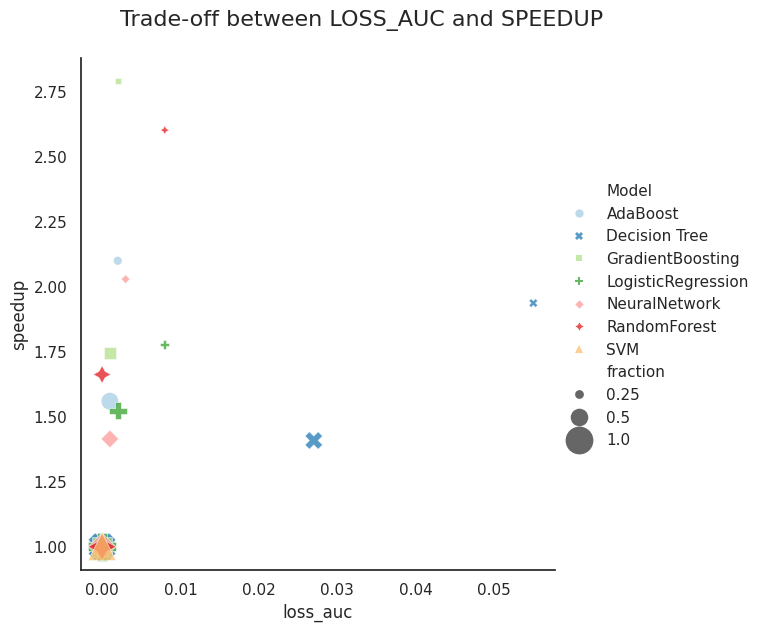

In [51]:
from matplotlib.ticker import MaxNLocator
sns.set_theme(style="white")

xc = "loss_auc"
yc = "speedup"

# Create the plot
g = sns.relplot(
    x=xc, y=yc, hue="Model", size="fraction",
    sizes=(40, 400), alpha=.75, palette='Paired',
    style='Model',
    height=6, data=data.query("drops == 0 and speedup<=4")
)

# Definir título principal para o gráfico inteiro
titulo = f"Trade-off between {xc.upper()} and {yc.upper()}"
g.fig.suptitle(titulo, y=1.05, fontsize=16)


plt.savefig(f'{titulo}.png', dpi=400, bbox_inches="tight")

In [52]:
data

,fraction,drops,Model,speedup,auc,time,loss_auc
0,0.25,0.0,AdaBoost,2.101,0.910,0.179,0.002
1,0.25,1.0,AdaBoost,2.173,0.739,0.016,0.002
2,0.25,2.0,AdaBoost,2.161,0.909,0.323,0.003
3,0.25,3.0,AdaBoost,2.238,0.896,0.018,0.002
4,0.25,4.0,AdaBoost,2.279,0.909,2.430,0.002
...,...,...,...,...,...,...,...
100,1.00,0.0,SVM,1.000,0.678,0.237,0.000
101,1.00,1.0,SVM,1.066,0.684,0.016,0.019
102,1.00,2.0,SVM,1.101,0.684,1.574,0.003
103,1.00,3.0,SVM,1.100,0.678,0.237,0.028


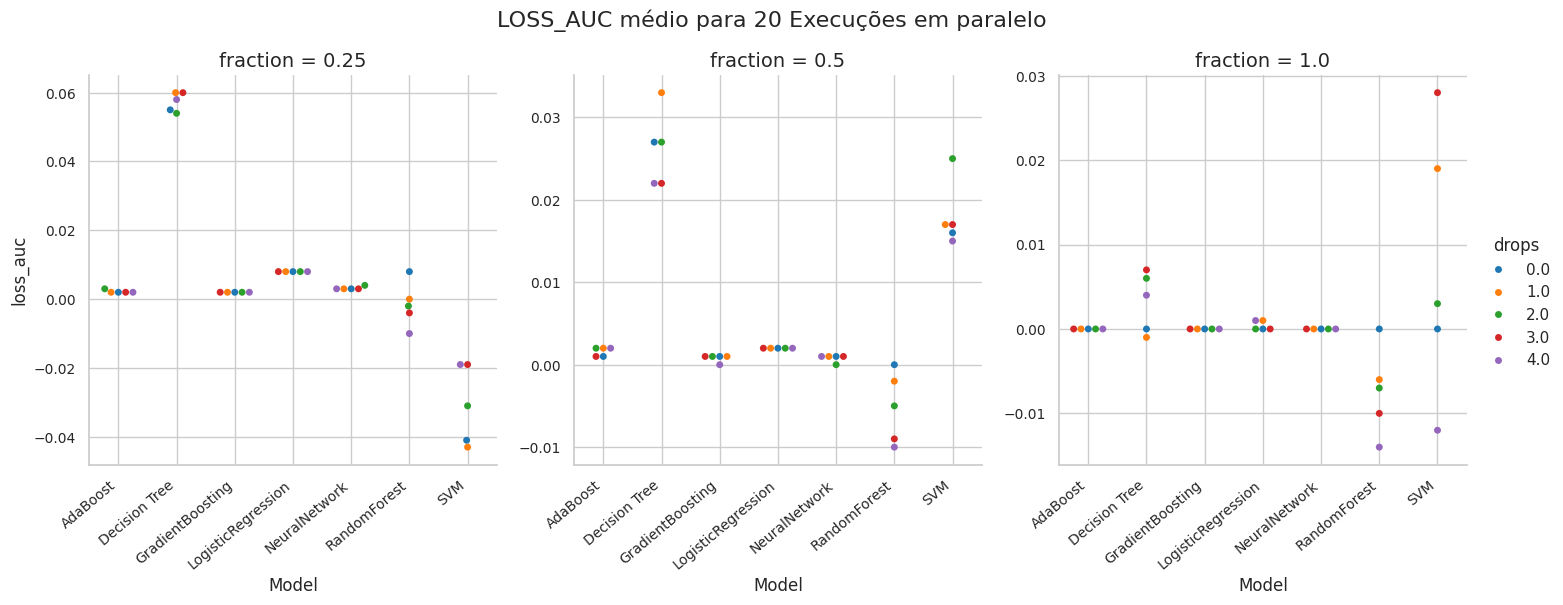

In [53]:
# Configurar o tema
sns.set_theme(style="whitegrid", palette="tab10")
xc = "Model"
yc = "loss_auc"
g = sns.catplot(
    data=data, 
    x=xc, 
    y=yc, 
    hue="drops",
    col="fraction", 
    kind="swarm", 
    sharey=False, 
    sharex=False, 
    legend=True,  
    log_scale=False,
    palette="tab10",
)

# Definir título principal para o gráfico inteiro
titulo = f"{yc.upper()} médio para 20 Execuções em paralelo"
g.fig.suptitle(titulo, y=1.05, fontsize=16)


# Aumentar o tamanho dos ticks dos eixos e rotacionar as labels
for ax in g.axes.flat:
    ax.tick_params(axis='both', labelsize=10)  # Ajustar o tamanho da fonte dos ticks
    ax.grid(True)  # Adicionar gridlines
    # Define the ticks explicitly
    ax.set_xticks(ax.get_xticks())
    # Rotacionar as labels do eixo x
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    

# Definir título para cada gráfico de coluna
for ax in g.axes.flat:
    ax.set_title(ax.get_title(), fontsize=14)


# plt.tight_layout()
plt.savefig(f'{titulo}.png', dpi=400, bbox_inches="tight")

In [6]:
df = pd.read_csv(filepath_or_buffer="RF.csv")
df

,Model,AUC,ExecutionTime,seed,fraction,drops,useclass,noise,n_jobs
0,RandomForest,0.886,5.998,1,1.000,0,True,0,1
1,RandomForest,0.883,3.682,1,1.000,0,True,0,2
2,RandomForest,0.890,2.666,1,1.000,0,True,0,4
3,RandomForest,0.882,4.119,1,1.000,0,True,0,8
4,RandomForest,0.884,4.850,1,1.000,0,True,0,16
...,...,...,...,...,...,...,...,...,...
975,RandomForest,0.889,3.259,20,0.016,0,True,0,4
976,RandomForest,0.874,3.265,20,0.016,0,True,0,8
977,RandomForest,0.889,3.309,20,0.016,0,True,0,16
978,RandomForest,0.894,3.009,20,0.016,0,True,0,32


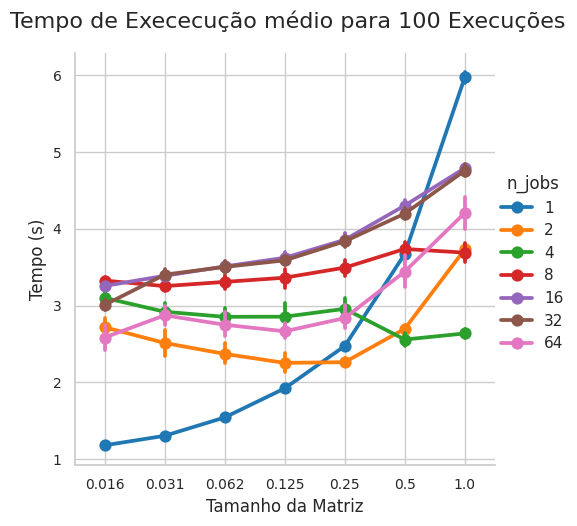

In [55]:

# Configurar o tema
sns.set_theme(style="whitegrid", palette="tab10")

g = sns.catplot(
    data=df,
    x="fraction", 
    y="ExecutionTime", 
    hue="n_jobs", 
    kind="point", 
    sharey=False, 
    sharex=False, 
    legend=True,  
    log_scale=False,
    palette="tab10",
)

# Definir título principal para o gráfico inteiro
titulo = "Tempo de Exececução médio para 100 Execuções"
g.fig.suptitle(titulo, y=1.05, fontsize=16)

# Definir rótulos dos eixos para cada eixo individual
g.set_axis_labels("Tamanho da Matriz", "Tempo (s)", fontsize=12)

# Aumentar o tamanho dos ticks dos eixos
for ax in g.axes.flat:
    ax.tick_params(axis='both', labelsize=10)  # Ajustar o tamanho da fonte dos ticks
    ax.grid(True)  # Adicionar gridlines

# Definir título para cada gráfico de coluna
for ax in g.axes.flat:
    ax.set_title(ax.get_title(), fontsize=14)

# plt.savefig(f'{titulo}.png', dpi=400)

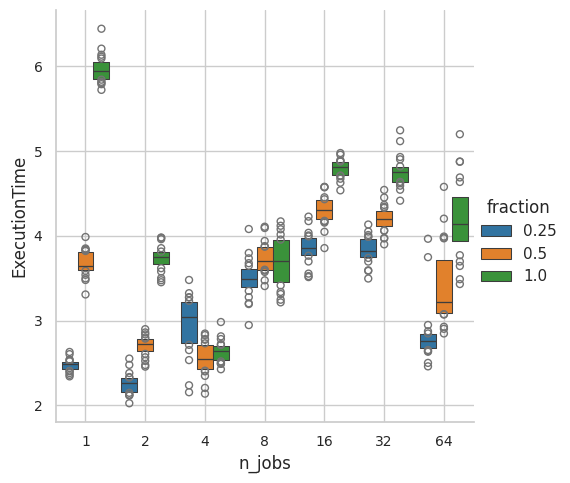

In [56]:

# Configurar o tema
sns.set_theme(style="whitegrid", palette="tab10")

g = sns.catplot(
    data=df.query("fraction >=0.25"),
    x="n_jobs", 
    y="ExecutionTime", 
    hue="fraction", 
    kind="boxen", 
    sharey=False, 
    sharex=False, 
    legend=True,  
    log_scale=False,
    palette="tab10",
)

# # Definir título principal para o gráfico inteiro
# titulo = "Tempo de Exececução médio para 100 Execuções"
# g.fig.suptitle(titulo, y=1.05, fontsize=16)

# # Definir rótulos dos eixos para cada eixo individual
# g.set_axis_labels("Tamanho da Matriz", "Tempo (s)", fontsize=12)

# Aumentar o tamanho dos ticks dos eixos
for ax in g.axes.flat:
    ax.tick_params(axis='both', labelsize=10)  # Ajustar o tamanho da fonte dos ticks
    ax.grid(True)  # Adicionar gridlines

# Definir título para cada gráfico de coluna
for ax in g.axes.flat:
    ax.set_title(ax.get_title(), fontsize=14)

# plt.savefig(f'{titulo}.png', dpi=400)

In [66]:
df_auc = df.drop(['ExecutionTime', "Model", "drops", "noise", "useclass"], axis=1).query("n_jobs == 1")
df_auc = df_auc.pivot(index=['fraction'],columns=['seed'], values='AUC')
loss_df = df_auc.loc[(1)] - df_auc
loss_df = loss_df.round(3)
loss_df = loss_df.melt(value_name='auc_loss', ignore_index=False).reset_index()
loss_df

,fraction,seed,auc_loss
0,0.016,1,0.005
1,0.031,1,-0.007
2,0.062,1,0.006
3,0.125,1,-0.005
4,0.250,1,-0.002
...,...,...,...
135,0.062,20,-0.028
136,0.125,20,-0.017
137,0.250,20,-0.020
138,0.500,20,0.005


In [69]:
df_time = df.drop(['AUC', "Model", "drops", "noise", "useclass"], axis=1)#.unstack(level=3)
df_time = df_time.pivot(index=['n_jobs', 'fraction'],columns='seed', values='ExecutionTime')

speedup_df = df_time.loc[(1,1)]/df_time
speedup_df = speedup_df.round(3)

speedup_df = speedup_df.melt(value_name='speedup', ignore_index=False).reset_index()
# speedup_df = speedup_df.drop('index', axis=1)
speedup_df['efficiency'] = speedup_df.speedup/speedup_df.n_jobs
speedup_df['time'] = df_time.melt(ignore_index=False).reset_index()["value"]
speedup_df

,n_jobs,fraction,seed,speedup,efficiency,time
0,1,0.016,1,5.049,5.049000,1.188
1,1,0.031,1,4.568,4.568000,1.313
2,1,0.062,1,4.001,4.001000,1.499
3,1,0.125,1,2.950,2.950000,2.033
4,1,0.250,1,2.400,2.400000,2.499
...,...,...,...,...,...,...
975,64,0.062,20,2.549,0.039828,2.282
976,64,0.125,20,2.100,0.032813,2.770
977,64,0.250,20,2.208,0.034500,2.634
978,64,0.500,20,1.465,0.022891,3.971


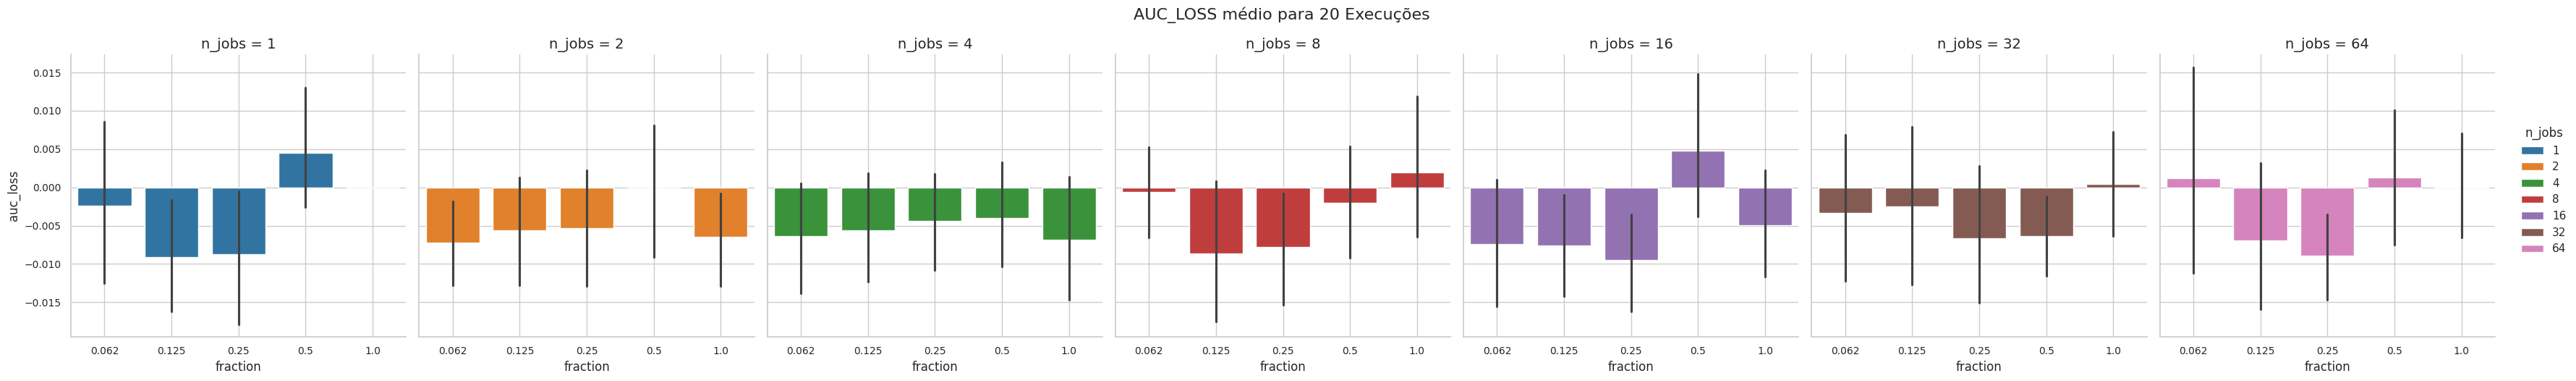

In [39]:
# Configurar o tema
sns.set_theme(style="whitegrid", palette="tab10")
xc="fraction"
yc="speedup"
g = sns.catplot(
    data=speedup_df.query("fraction >=0.06"),
    x=xc, 
    y=yc, 
    hue="n_jobs", 
    kind="bar",
    col="n_jobs", 
    sharey=True, 
    sharex=False, 
    legend=True,  
    log_scale=False,
    palette="tab10",
)

# Definir título principal para o gráfico inteiro
titulo = f"{yc.upper()} médio para 20 Execuções"
g.fig.suptitle(titulo, y=1.05, fontsize=16)

# Definir rótulos dos eixos para cada eixo individual
g.set_axis_labels(x_var=f"{xc}", f"{yc}", fontsize=12)

# Aumentar o tamanho dos ticks dos eixos
for ax in g.axes.flat:
    ax.tick_params(axis='both', labelsize=10)  # Ajustar o tamanho da fonte dos ticks
    ax.grid(True)  # Adicionar gridlines

# Definir título para cada gráfico de coluna
for ax in g.axes.flat:
    ax.set_title(ax.get_title(), fontsize=14)

# plt.savefig(f'{titulo}.png', dpi=400,bbox_inches="tight")

In [78]:
df_loss_auc = pd.concat([speedup_df.query("n_jobs == 1").reset_index().drop('index', axis=1), loss_df['auc_loss']], axis=1)
df_loss_auc.drop("n_jobs", axis=1, inplace=True)
df_loss_auc

,fraction,seed,speedup,efficiency,time,auc_loss
0,0.016,1,5.049,5.049,1.188,0.005
1,0.031,1,4.568,4.568,1.313,-0.007
2,0.062,1,4.001,4.001,1.499,0.006
3,0.125,1,2.950,2.950,2.033,-0.005
4,0.250,1,2.400,2.400,2.499,-0.002
...,...,...,...,...,...,...
135,0.062,20,3.965,3.965,1.467,-0.028
136,0.125,20,3.091,3.091,1.882,-0.017
137,0.250,20,2.420,2.420,2.404,-0.020
138,0.500,20,1.622,1.622,3.587,0.005


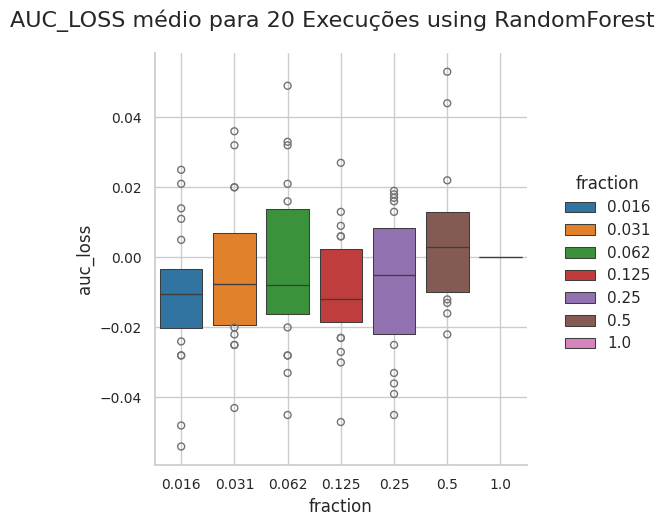

In [87]:
# Configurar o tema
sns.set_theme(style="whitegrid", palette="tab10")
xc="fraction"
yc="auc_loss"
g = sns.catplot(
    data=df_loss_auc.query("fraction >=0.0"),
    x=xc, 
    y=yc, 
    hue="fraction", 
    kind="boxen",
    # col="n_jobs", 
    sharey=True, 
    sharex=False, 
    legend=True,  
    log_scale=False,
    palette="tab10",
)

# Definir título principal para o gráfico inteiro
titulo = f"{yc.upper()} médio para 20 Execuções using RandomForest"
g.fig.suptitle(titulo, y=1.05, fontsize=16)

# Definir rótulos dos eixos para cada eixo individual
# g.set_axis_labels(x_var=f"{xc}", f"{yc}", fontsize=12)

# Aumentar o tamanho dos ticks dos eixos
for ax in g.axes.flat:
    ax.tick_params(axis='both', labelsize=10)  # Ajustar o tamanho da fonte dos ticks
    ax.grid(True)  # Adicionar gridlines

# Definir título para cada gráfico de coluna
for ax in g.axes.flat:
    ax.set_title(ax.get_title(), fontsize=14)

plt.savefig(f'{titulo}.png', dpi=400,bbox_inches="tight")